Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot as plt
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

### Check For Duplicates

In [3]:
df.duplicated().sum()
df = df.drop_duplicates()
df.duplicated().sum()

0

### Rename Columns

In [4]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Mileage', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [5]:

column_names = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'mileage', 
               'registration_month', 'fuel_type', 'brand', 'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
               'last_seen']

df.columns = column_names
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

### Analyze Data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354107 non-null  object
 1   price               354107 non-null  int64 
 2   vehicle_type        316623 non-null  object
 3   registration_year   354107 non-null  int64 
 4   gearbox             334277 non-null  object
 5   power               354107 non-null  int64 
 6   model               334406 non-null  object
 7   mileage             354107 non-null  int64 
 8   registration_month  354107 non-null  int64 
 9   fuel_type           321218 non-null  object
 10  brand               354107 non-null  object
 11  not_repaired        282962 non-null  object
 12  date_created        354107 non-null  object
 13  number_of_pictures  354107 non-null  int64 
 14  postal_code         354107 non-null  int64 
 15  last_seen           354107 non-null  object
dtypes:

In [7]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.0,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,0.0,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,0.0,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


After analyzing the data, you can see that the Registration Year and Power column have some outliers, considering the fact that the year "1000" and"9999" arent valid years, because there were no vehicles in the year 1000 and we havent reached the year 9999. Also, you can see that the minimun horse power is 0 and the max horse power is 20,000, also vehicles dont have 20k horse power or 0 hp, we are going to remove these outliers from the data.

### Removing Outliers from Registration Year Column

In [8]:
q1_price = df['registration_year'].quantile(.25)
q3_price = df['registration_year'].quantile(.75)
IQR = q3_price - q1_price

lower = q1_price - 1.5 * IQR
upper = q3_price + 1.5 * IQR

df_filtered = df[(df['registration_year'] >= lower) & (df['registration_year'] <= upper)]
df_filtered

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


### Removing Outliers from Power Column

In [9]:

q1_power = df['power'].quantile(.25)
q3_power = df['power'].quantile(.75)
IQR_power = q3_power - q1_power

lower_power = q1_power - 1.5 * IQR_power
upper_power = q3_power + 1.5 * IQR_power

new_df = df_filtered[(df_filtered['power'] >= lower_power) & (df_filtered['power'] <= upper_power)]
new_df

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


In [10]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340616 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        340616 non-null  object
 1   price               340616 non-null  int64 
 2   vehicle_type        304699 non-null  object
 3   registration_year   340616 non-null  int64 
 4   gearbox             322284 non-null  object
 5   power               340616 non-null  int64 
 6   model               322814 non-null  object
 7   mileage             340616 non-null  int64 
 8   registration_month  340616 non-null  int64 
 9   fuel_type           309616 non-null  object
 10  brand               340616 non-null  object
 11  not_repaired        272736 non-null  object
 12  date_created        340616 non-null  object
 13  number_of_pictures  340616 non-null  int64 
 14  postal_code         340616 non-null  int64 
 15  last_seen           340616 non-null  object
dtypes:

### Check For Missing Values

In [11]:
new_df.isna().sum()

date_crawled              0
price                     0
vehicle_type          35917
registration_year         0
gearbox               18332
power                     0
model                 17802
mileage                   0
registration_month        0
fuel_type             31000
brand                     0
not_repaired          67880
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [12]:
new_df['vehicle_type'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [13]:
filtered_df = new_df[['vehicle_type', 'brand', 'model']]
null_types = filtered_df[filtered_df['vehicle_type'].isnull()]
print(null_types['brand'].value_counts())

volkswagen        9339
opel              4828
ford              2735
bmw               2650
renault           2344
mercedes_benz     2300
audi              2298
fiat              1199
peugeot            944
sonstige_autos     844
seat               821
mazda              566
citroen            512
nissan             487
smart              455
honda              353
mitsubishi         338
toyota             337
skoda              303
hyundai            271
alfa_romeo         236
suzuki             223
kia                204
mini               197
volvo              192
chrysler           126
chevrolet          110
daihatsu           101
trabant             91
daewoo              78
subaru              72
rover               67
lancia              55
porsche             52
dacia               50
jeep                49
land_rover          26
lada                24
jaguar              20
saab                20
Name: brand, dtype: int64


In [14]:
null_types['model'].value_counts()

golf         3915
polo         1585
other        1584
corsa        1564
3er          1290
             ... 
amarok          1
crossfire       1
b_max           1
200             1
q3              1
Name: model, Length: 239, dtype: int64

By looking at the Vehicle Types with missing values, you can see that the top missing values are the Volkswagon Brand, and the top two missing values in the model column are the "Golf" and "Polo". Two vehicles created by Volkswagen. But still, it's not enough to where you can replace those missing values with Volkwagen brand and the models Golf and Polo.

In [15]:
new_df['gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [16]:
print(new_df['model'].unique())
print()
print()
print()
number_of_models = len(new_df['model'].unique())


['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe' 'passat'
 'navara' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'arosa'
 'other' 'c4' 'civic' 'punto' 'e_klasse' 'clio' 'kadett' 'kangoo' 'corsa'
 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'fiesta'
 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe'
 'scenic' 'a4' 'ka' 'a1' 'insignia' 'transporter' 'combo' 'focus' 'tt'
 'a6' 'jazz' 'omega' 'slk' '80' '147' 'z_reihe' 'sportage' 'sorento' 'v40'
 'ibiza' 'eos' 'touran' 'getz' 'a3' 'almera' 'megane' '7er' 'lupo' 'r19'
 'zafira' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo' 'tiguan'
 'i_reihe' 'mustang' 'espace' 'sharan' '6_reihe' 'panda' 'up' 'seicento'
 'ceed' '5_reihe' 'yeti' 'octavia' 'mii' 'rx_reihe' 'modus' 'fox' 'matiz'
 'beetle' 'c1' 'rio' 'touareg' 'logan' 'caddy' 'spider' 'cuore' 's_max'
 'a2' 'galaxy' 'c3' 'viano' '1_reihe' 'avensis' 'roomster' 'santa'
 'cooper' '4_reihe' 'a5' '500' 'laguna' 'ptcruiser' 'clk'

In [17]:
print(f"""
There are a total of {number_of_models} in the model column, 
since there's too many different values, and this feature won't change
the outcome of the manchine learning model, we are going to delete it.
      """)


There are a total of 248 in the model column, 
since there's too many different values, and this feature won't change
the outcome of the manchine learning model, we are going to delete it.
      


In [18]:
new_df['fuel_type'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [19]:
new_df['not_repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

After determining that there is no way to add a actual value to the "NaN" value, and the "Other" value, we are going to 
replace those values with the value: "unkown". The Column for Vehicle Model will be deleted from the dataframe.

### Filling Missing Values with "Unkown"

not repaired, fuel_type, vehicle type, gearbox

In [21]:
new_df.loc[new_df['vehicle_type'].isna(), 'vehicle_type'] = 'unknown'
new_df.loc[new_df['model'].isna(), 'model'] = 'unknown'
new_df.loc[new_df['not_repaired'].isna(), 'not_repaired'] = 'unknown'
new_df.loc[new_df['fuel_type'].isna(), 'fuel_type'] = 'unknown'
new_df.loc[new_df['gearbox'].isna(), 'gearbox'] = 'unknown'
new_df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [22]:
print(new_df['gearbox'].unique())
print(new_df['vehicle_type'].unique())
print(new_df['fuel_type'].unique())
print(new_df['not_repaired'].unique())

['manual' 'auto' 'unknown']
['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
['petrol' 'gasoline' 'unknown' 'lpg' 'other' 'hybrid' 'cng' 'electric']
['unknown' 'yes' 'no']


Now that we filled the missing values with "unknown", you can still see there is another value: "other". This value we must also change to "unknown", since we dont know what the value is here.

### Filling 'Other" Value with 'Unknown'

In [23]:
new_df.loc[new_df['vehicle_type'] == 'other', 'vehicle_type'] = 'unknown'
new_df['vehicle_type'].unique()

array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon'], dtype=object)

In [24]:
new_df.loc[new_df['fuel_type'] == 'other', 'fuel_type'] = 'unknown'
new_df['fuel_type'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'hybrid', 'cng',
       'electric'], dtype=object)

### Removing Columns we don't need in the dataframe

In [25]:
new_df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [26]:
dataframe = new_df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'model'], axis=1)
dataframe

,price,vehicle_type,registration_year,gearbox,power,mileage,fuel_type,brand,not_repaired
0,480,unknown,1993,manual,0,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,90000,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...
354364,0,unknown,2005,manual,0,150000,petrol,mitsubishi,yes
354365,2200,unknown,2005,unknown,0,20000,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,150000,gasoline,volkswagen,no


### Plots

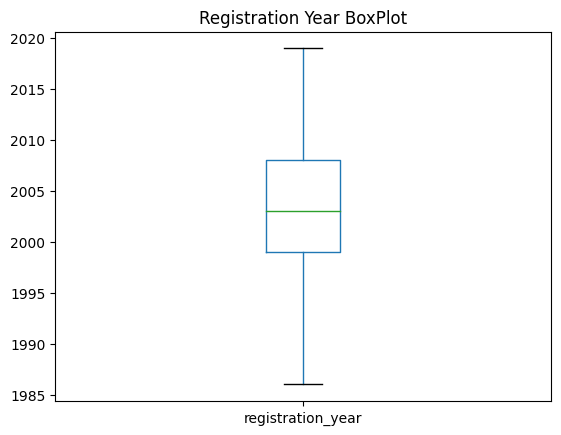

In [27]:
new_df['registration_year'].plot(
kind='box')
plt.title("Registration Year BoxPlot")
plt.show()

Looking at the boxplo for the registration year column, you can see that all the years in the dataframe are spread out evenly. There are no outliers in the years.

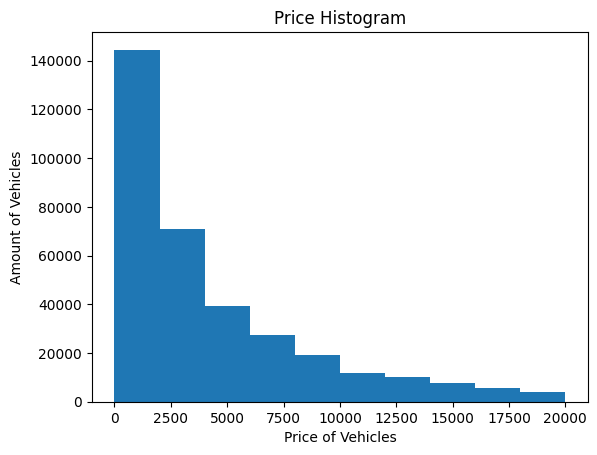

In [28]:
new_df['price'].plot(
kind='hist')
plt.title("Price Histogram")
plt.ylabel("Amount of Vehicles")
plt.xlabel("Price of Vehicles")
plt.show()

The histogram for the price column is skewed to the right, meaning, there are more vehicles with a lower price than vehicles with a higher price tag.

### Comparing Price vs Year of Registration

Im going to compare the price and the registration year columns, but first, we're going to drop the duplicated years to get the first occurence of each year and see how the prices increase or decrease as time progresses.

In [29]:
# Sort the DataFrame by 'registration_year'
sorted_df = new_df.sort_values(by='registration_year')

# Drop duplicates, keeping only the first occurrence of each registration year
single_sample_df = sorted_df.drop_duplicates(subset=['registration_year'], keep='first')

# Verify the result
print(single_sample_df)

            date_crawled  price vehicle_type  registration_year  gearbox  \
243013  16/03/2016 16:56    999        sedan               1986   manual   
328164  19/03/2016 12:38   7500        small               1987   manual   
15440   01/04/2016 21:49   4900        sedan               1988   manual   
298578  09/03/2016 20:54   9000  convertible               1989   manual   
148051  04/04/2016 18:43    900        wagon               1990   manual   
171762  10/03/2016 00:58    800        wagon               1991   manual   
167608  09/03/2016 20:42   1000        small               1992   manual   
78774   31/03/2016 04:03   3200        coupe               1993   manual   
343326  28/03/2016 19:37   1550  convertible               1994   manual   
209819  08/03/2016 16:56    450      unknown               1995  unknown   
203661  28/03/2016 11:54   1700        sedan               1996     auto   
284468  30/03/2016 21:52   1250        wagon               1997   manual   
170964  14/0

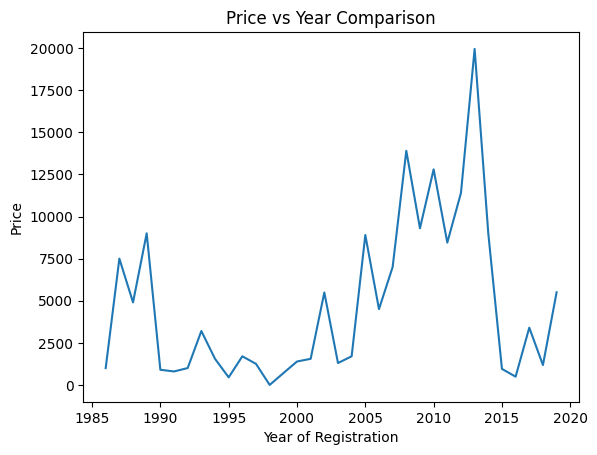

In [30]:
comparison_df = single_sample_df[['price', 'registration_year']]
x = comparison_df['registration_year']
y = comparison_df['price']
plt.plot(x, y)
plt.title('Price vs Year Comparison')
plt.ylabel("Price")
plt.xlabel("Year of Registration")
plt.show()

After comparing the price of the vehicles versus the year of registration, you can see that in the beggining, the prices skyrocket, the come back down during 1990 and stays roughly the same up until the year 2000 where it starts going up until year 2014, when they come back down.

### GearBox Plot

In [31]:
new_df['gearbox'].value_counts()

manual     262452
auto        59832
unknown     18332
Name: gearbox, dtype: int64

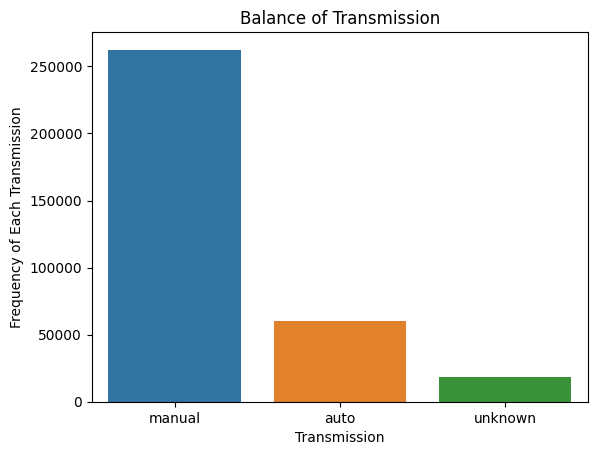

In [32]:
count_plot = sns.countplot(new_df['gearbox'])
count_plot.set_title('Balance of Transmission')
count_plot.set_ylabel("Frequency of Each Transmission")
count_plot.set_xlabel("Transmission")

plt.show()

Taking into consideration the types of transmissions in the vehicles in the dataframe, you can see that there is an imbalance of information, most of the vehicles being of manual transmission.

### Encoding our Dataframe

In [33]:
df_encoded = pd.get_dummies(dataframe, drop_first=True)
df_encoded

,price,registration_year,power,mileage,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
0,480,1993,0,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,0,2005,0,150000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
354365,2200,2005,0,20000,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
354366,1199,2000,101,125000,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
354367,9200,1996,102,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Model training

### Linear Regression

In [34]:
%%time

features = df_encoded.drop(['price'], axis=1)
target = df_encoded['price']

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=.3, random_state=13)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

model = LinearRegression()
%time model.fit(X_train_scaled, y_train)
print()
%time y_prediction = model.predict(X_valid_scaled)
print()
mse = mean_squared_error(y_valid, y_prediction)
rsme = np.sqrt(mse)
print(f"RSME: {rsme:.2f}")
print()

CPU times: user 1.7 s, sys: 338 ms, total: 2.03 s
Wall time: 1.99 s

CPU times: user 13.3 ms, sys: 25.9 ms, total: 39.1 ms
Wall time: 84.6 ms

RSME: 2639.58

CPU times: user 2.17 s, sys: 495 ms, total: 2.66 s
Wall time: 2.65 s


Linear Regresion:  
Train Time: 2.04 seconds   
Prediction Time: 90 milliseconds

### Dummy Regressor

In [35]:
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_train, y_train)
baseline_predictions = baseline_model.predict(X_valid)
baseline_mse = mean_squared_error(y_valid, baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline RMSE: {baseline_rmse:.2f}")
print()

Baseline RMSE: 4371.69



### Cross Validation

In [36]:
cv_scores = cross_val_score(model, features, target, cv=5, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print("Cross-Validation RMSE scores:", cv_rmse_scores)
print("Mean CV RMSE:", np.mean(cv_rmse_scores))

Cross-Validation RMSE scores: [2637.8357772  2645.57163331 2634.10157642 2634.70809885 2616.59578301]
Mean CV RMSE: 2633.7625737573194


### Random Forest Regressor

In [37]:
%%time

model_rf = RandomForestRegressor(n_estimators = 15, random_state=13, max_depth=17)
%time model_rf.fit(X_train, y_train)
print()
%time y_pred_rf = model_rf.predict(X_valid)
print()
mse_rf = mean_squared_error(y_valid, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print()

CPU times: user 20.7 s, sys: 36.6 ms, total: 20.8 s
Wall time: 20.8 s

CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 411 ms

Random Forest RMSE: 1715.53

CPU times: user 21.1 s, sys: 36.9 ms, total: 21.2 s
Wall time: 21.2 s


Random Forest Regresion:  
Train Time: 11.6 Seconds  
Prediction Time: 437 milliseconds

### Gradient Boosting Regressor

In [38]:
%%time

model_gradient = GradientBoostingRegressor(learning_rate=.4, n_estimators=10, max_depth=30, random_state=13)
%time model_gradient.fit(X_train, y_train)
print()
%time y_prediction_gradient = model_gradient.predict(X_valid)
print()
mse_gradient = mean_squared_error(y_prediction_gradient, y_valid)
rmse_gradient = np.sqrt(mse_gradient)
print(f"Gradient Boosting RMSE: {rmse_gradient:.2f}")
print()

CPU times: user 27.4 s, sys: 1.9 ms, total: 27.4 s
Wall time: 27.5 s

CPU times: user 432 ms, sys: 15.9 ms, total: 448 ms
Wall time: 450 ms

Gradient Boosting RMSE: 1945.64

CPU times: user 27.8 s, sys: 18 ms, total: 27.8 s
Wall time: 28 s


In [39]:
model_gradient = GradientBoostingRegressor(learning_rate=.7, n_estimators=20, max_depth=4, random_state=13)
%time model_gradient.fit(X_train, y_train)
print()
%time y_prediction_gradient = model_gradient.predict(X_valid)
print()
mse_gradient = mean_squared_error(y_prediction_gradient, y_valid)
rmse_gradient = np.sqrt(mse_gradient)
print(f"Gradient Boosting RMSE: {rmse_gradient:.2f}")
print()

CPU times: user 11.3 s, sys: 5.93 ms, total: 11.3 s
Wall time: 11.3 s

CPU times: user 71.6 ms, sys: 20.2 ms, total: 91.8 ms
Wall time: 91.6 ms

Gradient Boosting RMSE: 1924.66



In [40]:
model_gradient = GradientBoostingRegressor(max_features=7, min_samples_leaf=8, min_samples_split=4, random_state=13)
%time model_gradient.fit(X_train, y_train)
print()
%time y_prediction_gradient = model_gradient.predict(X_valid)
print()
mse_gradient = mean_squared_error(y_prediction_gradient, y_valid)
rmse_gradient = np.sqrt(mse_gradient)
print(f"Gradient Boosting RMSE: {rmse_gradient:.2f}")
print()

CPU times: user 6.4 s, sys: 17.8 ms, total: 6.42 s
Wall time: 6.44 s

CPU times: user 270 ms, sys: 7.57 ms, total: 277 ms
Wall time: 276 ms

Gradient Boosting RMSE: 2126.48



### Light GBM

In [41]:
%%time

model_lgb = LGBMRegressor(learning_rate=.5, num_leaves=300, max_depth=10, metric='rmse', random_seed=13)
%time model_lgb.fit(X_train, y_train)
print()
%time lgb_prediction = model_lgb.predict(X_valid)
print()
mse_lgb = mean_squared_error(lgb_prediction, y_valid)
rmse_lgb = np.sqrt(mse_lgb)
print(f"LGBM Regressor RMSE: {rmse_lgb:.2f}")
print()

CPU times: user 6.68 s, sys: 115 ms, total: 6.8 s
Wall time: 6.84 s

CPU times: user 1.57 s, sys: 6.65 ms, total: 1.58 s
Wall time: 1.59 s

LGBM Regressor RMSE: 1652.23

CPU times: user 8.26 s, sys: 122 ms, total: 8.39 s
Wall time: 8.44 s


In [42]:

%%time
model_lgb = LGBMRegressor(learning_rate=.7, num_leaves=100, max_depth=5, metric='rmse', random_seed=13)
%time model_lgb.fit(X_train, y_train)
print()
%time lgb_prediction = model_lgb.predict(X_valid)
print()
mse_lgb = mean_squared_error(lgb_prediction, y_valid)
rmse_lgb = np.sqrt(mse_lgb)
print(f"LGBM Regressor RMSE: {rmse_lgb:.2f}")
print()

CPU times: user 2.83 s, sys: 41.6 ms, total: 2.87 s
Wall time: 2.89 s

CPU times: user 839 ms, sys: 7.75 ms, total: 847 ms
Wall time: 890 ms

LGBM Regressor RMSE: 1717.94

CPU times: user 3.68 s, sys: 49.5 ms, total: 3.73 s
Wall time: 3.78 s


In [45]:
model_lgb = LGBMRegressor(n_estimators=10, max_depth=5, num_leaves=40, random_seed=13)
%time model_lgb.fit(X_train, y_train)
print()
%time lgb_prediction = model_lgb.predict(X_valid)
print()
mse_lgb = mean_squared_error(lgb_prediction, y_valid)
rmse_lgb = np.sqrt(mse_lgb)
print(f"LGBM Regressor RMSE: {rmse_lgb:.2f}")
print()

CPU times: user 1.04 s, sys: 43.1 ms, total: 1.09 s
Wall time: 1.09 s

CPU times: user 128 ms, sys: 11.7 ms, total: 140 ms
Wall time: 109 ms

LGBM Regressor RMSE: 2602.13



### CatBoost

In [50]:
%%time

model_cat = CatBoostRegressor(iterations=20, learning_rate=.7, depth=10, random_seed=13, loss_function='RMSE', verbose=False)
%time model_cat.fit(X_train, y_train)
print()
%time cat_prediction = model_cat.predict(X_valid)
print()
mse_cat = mean_squared_error(cat_prediction, y_valid)
rmse_cat = np.sqrt(mse_cat)
print()
print(f"CatBoost RMSE: {rmse_cat:.2f}")
print()

CPU times: user 2.67 s, sys: 3.21 ms, total: 2.67 s
Wall time: 2.75 s

CPU times: user 27.5 ms, sys: 0 ns, total: 27.5 ms
Wall time: 27.3 ms


CatBoost RMSE: 1760.33

CPU times: user 2.7 s, sys: 3.26 ms, total: 2.7 s
Wall time: 2.78 s


In [51]:
%%time

model_cat = CatBoostRegressor(iterations=10, learning_rate=.5, depth=15, random_seed=13, loss_function='RMSE', silent=True)
%time model_cat.fit(X_train, y_train)
print()
%time cat_prediction = model_cat.predict(X_valid)
print()
mse_cat = mean_squared_error(cat_prediction, y_valid)
rmse_cat = np.sqrt(mse_cat)
print()
print(f"CatBoost RMSE: {rmse_cat:.2f}")
print()

CPU times: user 4.59 s, sys: 808 ms, total: 5.4 s
Wall time: 5.48 s

CPU times: user 23.8 ms, sys: 0 ns, total: 23.8 ms
Wall time: 23.6 ms


CatBoost RMSE: 1776.91

CPU times: user 4.62 s, sys: 808 ms, total: 5.43 s
Wall time: 5.51 s


In [ ]:
# Define the parameter grid
param_grid = {
    'iterations': [50, 100],
    'learning_rate': [0.1, 0.3],
    'depth': [6, 10]
}

# Initialize the CatBoostRegressor model
model_cat = CatBoostRegressor(random_seed=13, loss_function='RMSE', silent=True)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model_cat, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the model and search for the best hyperparameters
%time grid_search.fit(X_train, y_train)

# Get the best model
best_model_cat = grid_search.best_estimator_

# Make predictions
%time cat_prediction = best_model_cat.predict(X_valid)

# Calculate RMSE
mse_cat = mean_squared_error(cat_prediction, y_valid)
rmse_cat = np.sqrt(mse_cat)
print(f"Best CatBoost RMSE: {rmse_cat:.2f}")

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

## Model analysis

### Conclusion

#### Training and Prediction Times by Model:

                                    Linear Regresion:  
                                    Train Time: 344 milliseconds  
                                    Prediction Time: 96.2 milliseconds

                                    Random Forest Regresion:  
                                    Train Time: 11.6 Seconds  
                                    Prediction Time: 437 milliseconds

                                    Gradient Boosting Regresion:  
                                    Train Time:29 seconds  
                                    Prediction Time: 196 milliseconds

                                    Light GMB:  
                                    Train Time:2.92 seconds  
                                    Prediction Time: 893 milliseconds  

                                    CatBoost:  
                                    Train Time:1.18 seconds  
                                    Prediction Time: 16.6 milliseconds  

            After analyzing all the models created, The Linear Regressor Model is the fastest out of them all with a wall time of 504 milliseconds, but quality wise, its not the most accurate, with a RMSE of 2771.18. The model with the best quality is the LightGMB, with the RMSE of 1651.83, with a wall time of 2.92 seconds. After using the Gradient Boosting Regressor, this model was able to achieve a RMSE of 2031.65, with a wall time of 29 seconds, being the slowest of all the models created. But, a combination of quality and speed would be the Catboost Model and the Light GBM model. 
            In conclusion, the best model for the data analysis would be the Light GMB Model, best performance and speed out of all the models created. 